In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import datetime

In [2]:
def load_logs():
    df = pd.read_csv("logs.csv")
    # Update the date from UTC to local time
    df["date"] = (
        pd.to_datetime(df["date"], utc=True)
        .dt.tz_convert("Europe/Paris")
        .dt.tz_localize(None)
    )
    return df


df = load_logs()

if df["date"].max() < datetime.datetime.now() - datetime.timedelta(minutes=10):
    print("Fetching new logs")
    assert os.system("scp degen-farming:degen-farming-bots/logs.csv ./logs.csv") == 0
    df = load_logs()

Fetching new logs


In [3]:
latest = df.iloc[-1]

print(f"Latest log: {latest['date']}")
print(f"Operator ({latest['operator_address']}): {latest['operator_balance']} ETH")
print(
    f"Wallet ({latest['wallet_address']}): health factor: {latest['aave_health_factor']}"
)
print(
    f"Aave balance: {latest['aave_deposit_usdc']} USDC, {latest['aave_borrow_weth']} WETH"
)
print(
    f"APY: USDC: {latest['aave_usdc_apy']:.2f}%, WETH: -{latest['aave_weth_apy']:.2f}%"
)
print(
    f"Staked balance: {latest['aero_staked_usdc']} USDC, {latest['aero_staked_weth']} WETH"
)
print(f"Staked: ${latest['aero_staked_usd']:.2f}, APR: {latest['aero_apr']:.2f}%")
print(f"Pending rewards: {latest['aero_rewards']} AERO")
print(
    f"Wallet: {latest['wallet_balance_usdc']} USDC, {latest['wallet_balance_weth']} WETH"
)
print(f"Wallet: ${latest['wallet_balance_usd']:.2f}, APR: {latest['global_apr']:.2f}%")

start_date = pd.to_datetime("2024-04-20 19:39:31")
start_balance = 100_000

delta_time = latest["date"] - start_date
delta_balance = latest["wallet_balance_usd"] - start_balance

print(f"\nOverall performance:")
print(f"Running for {delta_time.days} days {delta_time.seconds // 3600} hours {delta_time.seconds % 3600 // 60} minutes")
print(f"Balance change: ${delta_balance:.2f}")
print(f"APR: {(delta_balance / start_balance) / (delta_time.total_seconds() / 31536000) * 100:.2f}%")

Latest log: 2024-10-09 16:20:04
Operator (0xdd057c18456bb2ccff113def8c5e3ba210d6a9b4): 0.0171994150600642 ETH
Wallet (0xdded5bd58d4a1e57b2d53a344a7b9e18a88012f9): health factor: 1.233433973659667
Aave balance: 59163.875361 USDC, 15.374293081577262 WETH
APY: USDC: 4.90%, WETH: -2.39%
Staked balance: 42696.651606 USDC, 17.564093273952693 WETH
Staked: $85428.18, APR: 13.40%
Pending rewards: 36.38197377309224 AERO
Wallet: 71.817358 USDC, 0.0 WETH
Wallet: $107291.74, APR: 13.30%

Overall performance:
Running for 171 days 20 hours 40 minutes
Balance change: $7291.74
APR: 15.49%


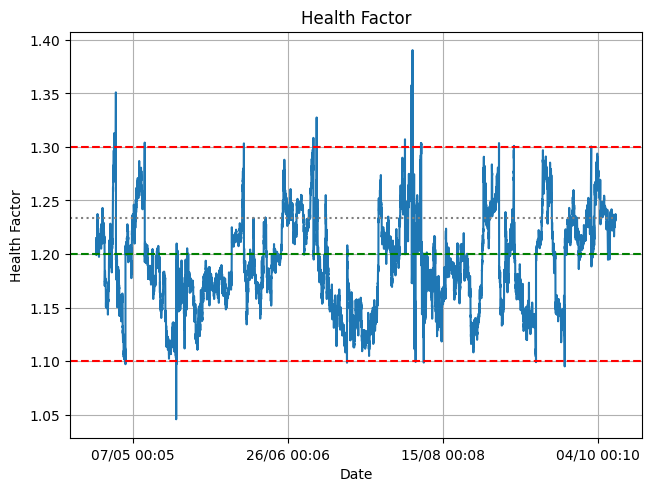

In [4]:
date = df["date"]
health = df["aave_health_factor"]

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, health, label="Health Factor")
ax.set_title("Health Factor")
ax.set_xlabel("Date")
ax.set_ylabel("Health Factor")

# Add red dot line at 1.1 and 1.3, green dot line at 1.2
ax.axhline(y=1.1, color="r", linestyle="--", label="1.1")
ax.axhline(y=1.2, color="g", linestyle="--", label="1.2")
ax.axhline(y=1.3, color="r", linestyle="--", label="1.3")

ax.axhline(y=health.iloc[-1], xmax=0.95, linestyle=":", color="gray")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

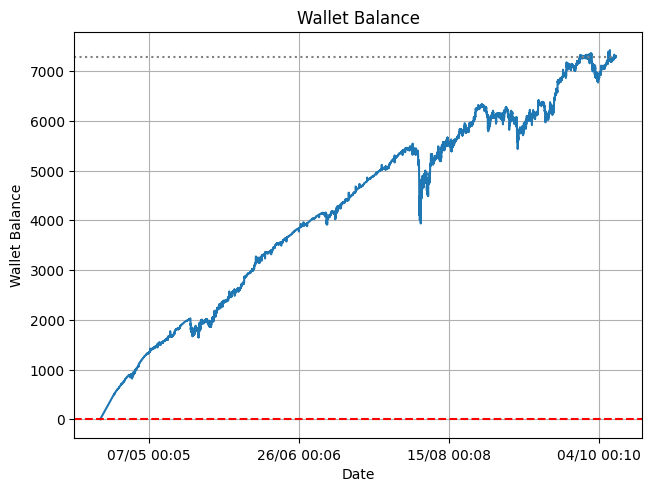

In [5]:
date = df["date"]
wallet_balance_usd = df["wallet_balance_usd"]

# Convert start_date and start_balance to pandas Series
start_date_series = pd.Series([start_date])
start_balance_series = pd.Series([start_balance])

# Append start_date and start_balance to date and wallet_balance_usd
date = pd.concat([start_date_series, date]).reset_index(drop=True)
wallet_balance_usd = pd.concat([start_balance_series, wallet_balance_usd]).reset_index(drop=True)

wallet_balance_usd = wallet_balance_usd - start_balance

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(
    date,
    wallet_balance_usd,
    label="Wallet Balance",
)
ax.set_title("Wallet Balance")
ax.set_xlabel("Date")
ax.set_ylabel("Wallet Balance")
ax.grid(True)

ax.axhline(y=wallet_balance_usd.iloc[-1], xmax=0.95, linestyle=":", color="gray")
ax.axhline(y=0, xmax=1, linestyle="--", color="red")

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

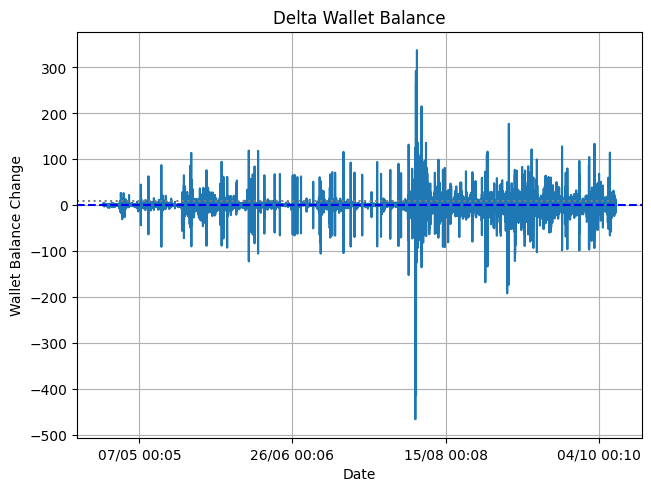

In [6]:
date = df["date"]
delta_wallet_balance_usd = df["wallet_balance_usd"] - df["wallet_balance_usd"].shift(1)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, delta_wallet_balance_usd)
ax.set_title("Delta Wallet Balance")
ax.set_xlabel("Date")
ax.set_ylabel("Wallet Balance Change")

# Add block dot line at 1
ax.axhline(y=0, color="b", linestyle="--", label="0")
ax.axhline(y=delta_wallet_balance_usd.iloc[-1], xmax=0.95, linestyle=":", color="gray")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

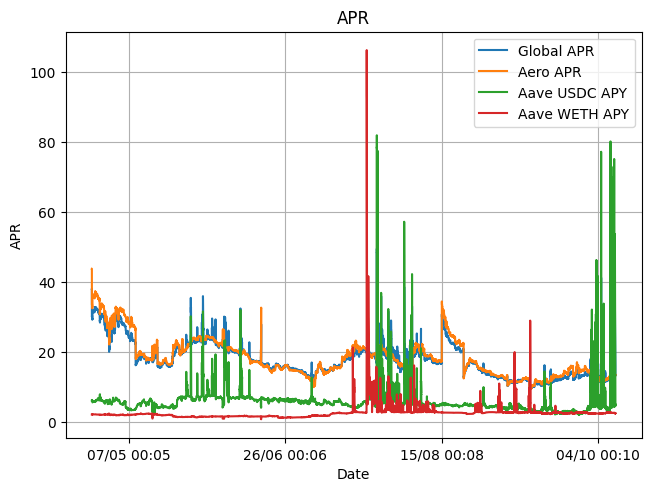

In [7]:
date = df["date"]
global_apr = df["global_apr"]
aero_apr = df["aero_apr"]
aave_usdc_apy = df["aave_usdc_apy"]
aave_weth_apy = df["aave_weth_apy"]

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, global_apr, label="Global APR")
ax.plot(date, aero_apr, label="Aero APR")
ax.plot(date, aave_usdc_apy, label="Aave USDC APY")
ax.plot(date, aave_weth_apy, label="Aave WETH APY")
ax.set_title("APR")
ax.set_xlabel("Date")
ax.set_ylabel("APR")
ax.grid(True)

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend()
plt.show()

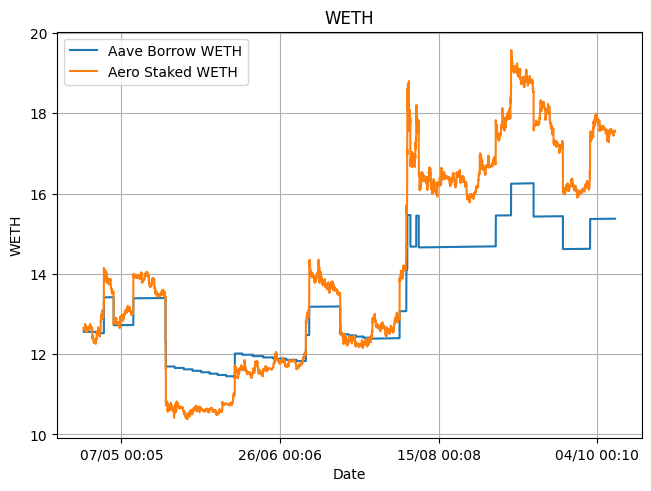

In [8]:
date = df["date"]
aave_borrow_weth = df["aave_borrow_weth"]
aero_staked_weth = df["aero_staked_weth"]

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, aave_borrow_weth, label="Aave Borrow WETH")
ax.plot(date, aero_staked_weth, label="Aero Staked WETH")
ax.set_title("WETH")
ax.set_xlabel("Date")
ax.set_ylabel("WETH")
ax.grid(True)

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend()
plt.show()

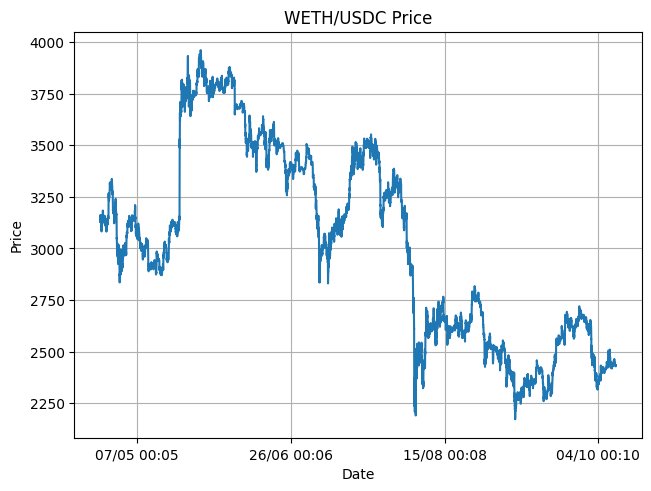

In [9]:
date = df["date"]
price = df["aero_staked_usdc"] / df["aero_staked_weth"]

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, price, label="Weth price")
ax.set_title("WETH/USDC Price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

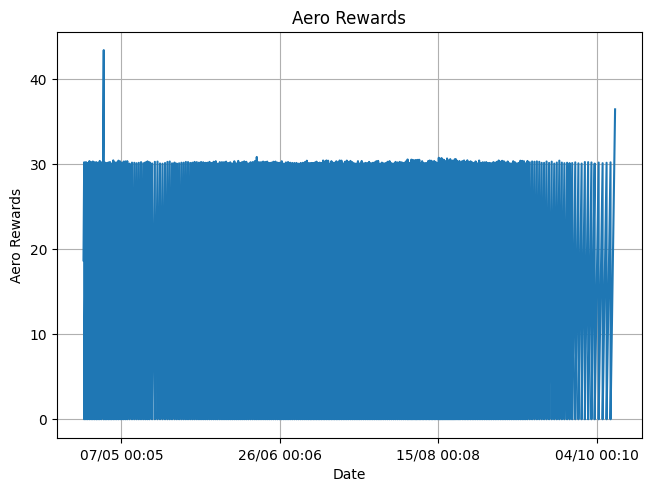

In [10]:
date = df["date"]
aero_rewards = df["aero_rewards"]

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, aero_rewards, label="Aero Rewards")
ax.set_title("Aero Rewards")
ax.set_xlabel("Date")
ax.set_ylabel("Aero Rewards")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()